In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import joblib

import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc
import math
import sklearn
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df_BTC  = pd.read_csv("/content/gdrive/MyDrive/NESTQUANT/data/BTC/BTCUSDT_obeserved.csv")
BTC_label = pd.read_csv("/content/gdrive/MyDrive/NESTQUANT/data/BTC/BTCUSDT_label.csv")

df_BTC = df_BTC.set_index("OPEN_TIME")
BTC_label = BTC_label.set_index("OPEN_TIME")
df_BTC_full_mean  = df_BTC.join(BTC_label, how= 'inner')

In [4]:
def get_return(df, time):
    dff = df.copy()
    dff[f'RETURN_{time}'] = np.log(dff['CLOSE'] / dff['CLOSE'].shift(time))
    return dff

def get_vola(df, time, isReturn):
    dff = df.copy()
    if isReturn == False:
        dff = get_return(dff, 1)
    dff[f"std_{time}"] = dff[f'RETURN_1'].rolling(window=time).std()
    dff["std_long"] = dff[f'RETURN_1'].rolling(window=336).std()
    dff[f"VOLABILITY_{time}"]  = dff[f"std_{time}"]/ dff["std_long"]


    return dff


In [5]:
for i in range(1, 4):
    df_BTC_full_mean = get_return(df_BTC_full_mean, i)
    if i == 1:
        continue
    else:
        df_BTC_full_mean = get_vola(df_BTC_full_mean, i, True)

column_to_move = 'LABEL'
desired_position = 64

# Create a list of column names in the desired order
columns = df_BTC_full_mean.columns.tolist()
columns.remove(column_to_move)
columns.insert(desired_position, column_to_move)

# Reorder the columns in the dataframe
df_BTC_full_mean = df_BTC_full_mean[columns]

df_BTC_full_mean = df_BTC_full_mean.dropna()
df_BTC_full_mean = df_BTC_full_mean.drop(["YEAR_AND_MONTH","SYMBOL","QUOTE_ASSET_VOLUME","NUMBER_OF_TRADES","TAKER_BUY_BASE_ASSET_VOLUME","TAKER_BUY_QUOTE_ASSET_VOLUME"], axis =1)

for i in range(2, 4):
    df_BTC_full_mean = df_BTC_full_mean.drop([f'std_{i}'], axis =1)
df_BTC_full_mean = df_BTC_full_mean.drop([f'std_long'], axis =1)

df_BTC_full_meann = df_BTC_full_mean.reset_index().drop("OPEN_TIME", axis = 1)

In [6]:
length=1000 ## Learn from previous 1000 hours (Sequence length = 1000)
X =  df_BTC_full_mean

training_set = X.iloc[:40000].values
test_set = X.iloc[40000:].values
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled=sc.transform(test_set)
X_train = []
y_train = []
for i in range(length, len(training_set)):
    X_train.append(training_set_scaled[i-length:i, :-1]) # change this
    y_train.append(training_set_scaled[i, -1]) # change this
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 10))

X_test = []
y_test = []
for i in range(length, len(test_set)):
    X_test.append(test_set_scaled[i-length:i, :-1])
    y_test.append(test_set_scaled[i, -1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 10))

In [7]:
filepath = '/content/gdrive/MyDrive/NESTQUANT/models/cp.ckpt'

In [8]:
modelss = tf.keras.saving.load_model(
    filepath, custom_objects=None, compile=True, safe_mode=True,
)

In [17]:
X.iloc[41000:]

,OPEN,HIGH,LOW,CLOSE,VOLUME,RETURN_1,RETURN_2,VOLABILITY_2,RETURN_3,VOLABILITY_3,LABEL
OPEN_TIME,,,,,,,,,,,
1.654855e+12,29897.09,29936.49,29875.09,29924.94,199.98594,-0.003074,-0.004051,0.233243,-0.006668,0.173454,0.321982
1.654859e+12,30000.64,30007.67,29982.08,29989.24,65.35583,0.002146,-0.000928,0.580834,-0.001905,0.413347,0.359464
1.654862e+12,30020.56,30053.04,29989.09,30017.61,131.14518,0.000946,0.003092,0.133598,0.000018,0.430197,0.385128
1.654866e+12,29642.60,29711.69,29605.49,29711.68,434.79182,-0.010244,-0.009298,1.245372,-0.007152,1.075565,0.360226
1.654870e+12,29396.04,29396.04,29222.67,29357.80,1020.33797,-0.011982,-0.022226,0.192477,-0.021280,1.098845,0.369254
...,...,...,...,...,...,...,...,...,...,...,...
1.677611e+12,23481.63,23492.84,23472.24,23473.37,634.81084,-0.002441,0.000915,0.689260,-0.003041,0.648873,0.448246
1.677614e+12,23263.38,23272.46,23167.15,23189.26,2865.91452,-0.012177,-0.014619,1.150425,-0.011263,1.311721,0.470401
1.677618e+12,23270.59,23277.98,23192.12,23209.65,1829.57503,0.000879,-0.011298,1.542802,-0.013740,1.133976,0.468764


In [9]:
pred=modelss.predict(X_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
test

198/198 [==============================] - 119s 591ms/step


,test,pred
0,0.321982,0.410776
1,0.359464,0.410809
2,0.385128,0.410731
3,0.360226,0.410571
4,0.369254,0.410363
...,...,...
6321,0.448246,0.411630
6322,0.470401,0.411882
6323,0.468764,0.412135
6324,0.474988,0.412384


In [14]:
y_test

array([0.3219822 , 0.35946392, 0.38512843, ..., 0.46876416, 0.47498767,
       0.48482432])

In [21]:
cd /content/gdrive/MyDrive/NESTQUANT/data/predicted_data

/content/gdrive/MyDrive/NESTQUANT/data/predicted_data


In [19]:
submit=pd.DataFrame(columns=['OPEN_TIME','PREDICTION'])
submit['OPEN_TIME']=X.iloc[41000:].index
submit['PREDICTION']=pred.flatten()


,OPEN_TIME,PREDICTION
0,1.654855e+12,0.410776
1,1.654859e+12,0.410809
2,1.654862e+12,0.410731
3,1.654866e+12,0.410571
4,1.654870e+12,0.410363
...,...,...
6321,1.677611e+12,0.411630
6322,1.677614e+12,0.411882
6323,1.677618e+12,0.412135
6324,1.677622e+12,0.412384


In [22]:
submit.to_csv('test3.csv')

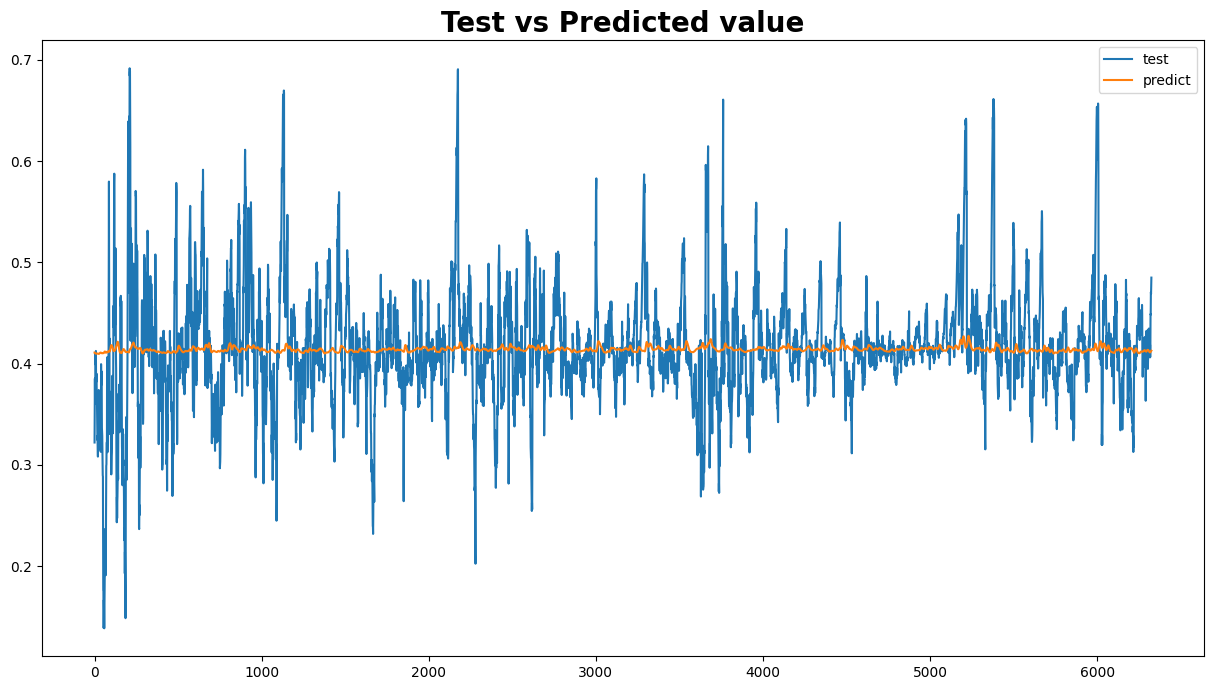

In [11]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(test)
plt.legend(['test','predict'])
